# Image Segmentation PyTorch

- https://www.coursera.org/learn/deep-learning-with-pytorch-image-segmentation/ungradedLab/lbhgf/deep-learning-with-pytorch-image-segmentation

- https://smp.readthedocs.io/en/latest/losses.html#diceloss
- https://github.com/qubvel/segmentation_models.pytorch


## DiceLoss()

https://blog.csdn.net/liangjiu2009/article/details/107352164


# Download Dataset


In [1]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


# Imports


In [2]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Helper func `show_image()`


In [3]:
def show_image(image, mask, pred_image=None):
    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.set_title("IMAGE")
        ax1.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")

        ax2.set_title("GROUND TRUTH")
        ax2.imshow(mask.permute(1, 2, 0).squeeze(), cmap="gray")

    elif pred_image != None:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

        ax1.set_title("IMAGE")
        ax1.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")

        ax2.set_title("GROUND TRUTH")
        ax2.imshow(mask.permute(1, 2, 0).squeeze(), cmap="gray")

        ax3.set_title("MODEL OUTPUT")
        ax3.imshow(pred_image.permute(1, 2, 0).squeeze(), cmap="gray")

# Setup Configurations


In [4]:
CSV_File = "data/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "data/Human-Segmentation-Dataset-master"

has_mps = torch.backends.mps.is_built()
DEVICE = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

NUM_EPOCHS = 25
LR = 3e-3
IMAGE_SIZE = 320
BATCH_SIZE = 32

# https://smp.readthedocs.io/en/latest/encoders.html
ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [5]:
df = pd.read_csv(CSV_File)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [6]:
print(f"len of df: {len(df)}")

len of df: 290


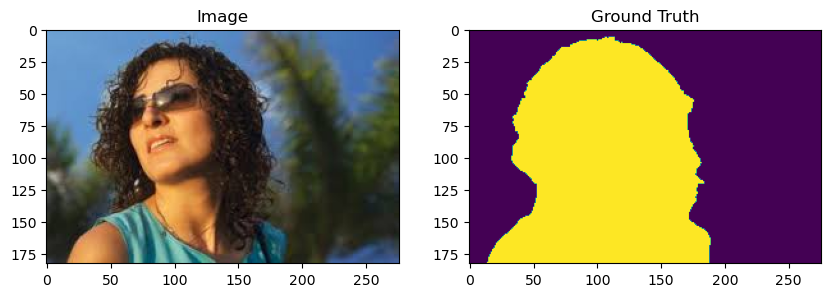

In [7]:
idx = 0

row = df.iloc[idx]

image_path = row["images"]  # 'Human-Segmentation-Dataset-master/Training_Images/1.jpg'
mask_path = row["masks"]  # 'Human-Segmentation-Dataset-master/Ground_Truth/1.png'


image = cv2.imread(image_path)  # <class 'numpy.ndarray'> (183, 276, 3)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # <class 'numpy.ndarray'> (183, 276, 3)

mask = cv2.imread(mask_path)  # <class 'numpy.ndarray'> (183, 276, 3)
mask = (
    cv2.imread(mask_path, cv2.IMREAD_UNCHANGED) / 255.0
)  # <class 'numpy.ndarray'> (183, 276)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.set_title("Image")
ax1.imshow(image)
ax2.set_title("Ground Truth")
ax2.imshow(mask)

plt.show()

(183, 276, 3)


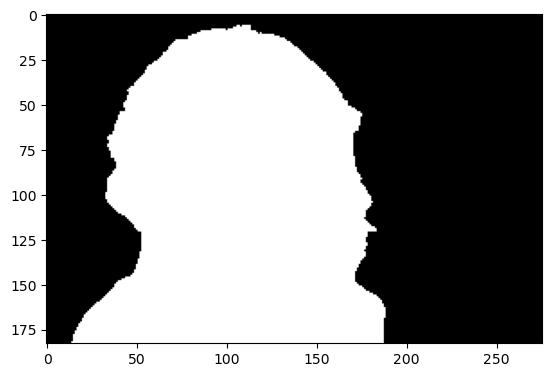

(183, 276)


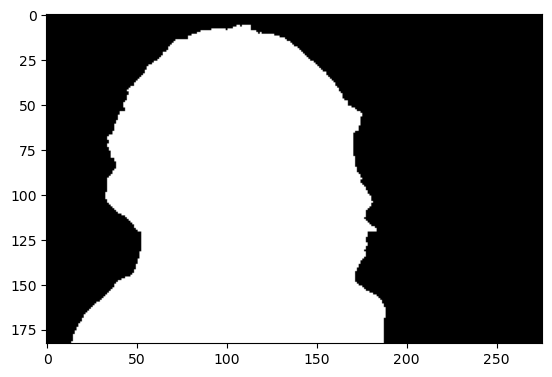

In [23]:
mask_3channel = cv2.imread(mask_path)
print(mask_3channel.shape)

plt.imshow(mask_3channel)

plt.show()

mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED) / 255.0
print(mask.shape)
plt.imshow(mask, cmap="gray")
plt.show()

Before COLOR_BGR2RGB
Image type: <class 'numpy.ndarray'> | Image shape: (183, 276, 3)
After COLOR_BGR2RGB
Image type: <class 'numpy.ndarray'> | Image shape: (183, 276, 3)

Before IMREAD_UNCHANGED
Mask type: <class 'numpy.ndarray'> | Mask shape: (183, 276, 3)
After IMREAD_UNCHANGED
Mask type: <class 'numpy.ndarray'> | Mask shape: (183, 276)


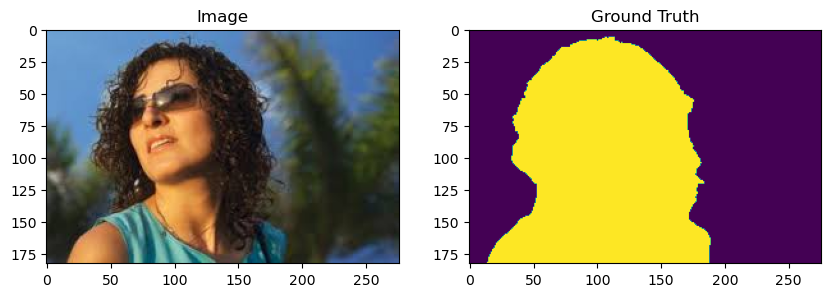

Before COLOR_BGR2RGB
Image type: <class 'numpy.ndarray'> | Image shape: (408, 612, 3)
After COLOR_BGR2RGB
Image type: <class 'numpy.ndarray'> | Image shape: (408, 612, 3)

Before IMREAD_UNCHANGED
Mask type: <class 'numpy.ndarray'> | Mask shape: (408, 612, 3)
After IMREAD_UNCHANGED
Mask type: <class 'numpy.ndarray'> | Mask shape: (408, 612)


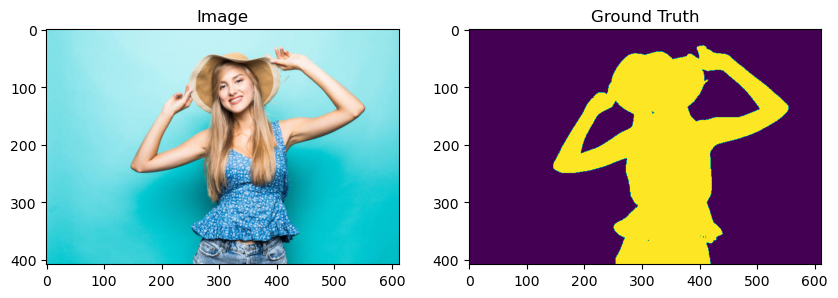

Before COLOR_BGR2RGB
Image type: <class 'numpy.ndarray'> | Image shape: (195, 259, 3)
After COLOR_BGR2RGB
Image type: <class 'numpy.ndarray'> | Image shape: (195, 259, 3)

Before IMREAD_UNCHANGED
Mask type: <class 'numpy.ndarray'> | Mask shape: (195, 259, 3)
After IMREAD_UNCHANGED
Mask type: <class 'numpy.ndarray'> | Mask shape: (195, 259)


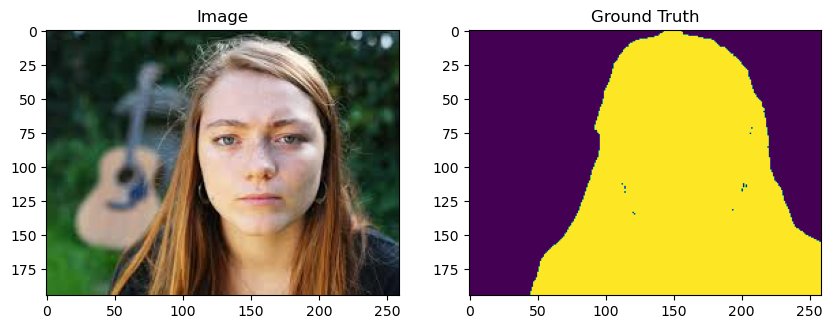

In [8]:
def show_original_and_mask(idx=0, df=df):

    row = df.iloc[idx]

    image_path = row[
        "images"
    ]  # 'Human-Segmentation-Dataset-master/Training_Images/1.jpg'
    mask_path = row["masks"]  # 'Human-Segmentation-Dataset-master/Ground_Truth/1.png'

    image = cv2.imread(image_path)  # <class 'numpy.ndarray'> (183, 276, 3)
    print(
        f"Before COLOR_BGR2RGB\nImage type: {type(image)} | Image shape: {image.shape}"
    )
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # <class 'numpy.ndarray'> (183, 276, 3)
    print(
        f"After COLOR_BGR2RGB\nImage type: {type(image)} | Image shape: {image.shape}\n"
    )

    mask = cv2.imread(mask_path)  # <class 'numpy.ndarray'> (183, 276, 3)
    print(
        f"Before IMREAD_UNCHANGED\nMask type: {type(mask)} | Mask shape: {mask.shape}"
    )
    mask = (
        cv2.imread(mask_path, cv2.IMREAD_UNCHANGED) / 255.0
    )  # <class 'numpy.ndarray'> (183, 276)
    print(f"After IMREAD_UNCHANGED\nMask type: {type(mask)} | Mask shape: {mask.shape}")

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax1.set_title("Image")
    ax1.imshow(image)
    ax2.set_title("Ground Truth")
    ax2.imshow(mask)

    plt.show()

    return image, mask


image, mask = show_original_and_mask(idx=0, df=df)
image, mask = show_original_and_mask(idx=4, df=df)
image, mask = show_original_and_mask(idx=6, df=df)

In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"len of train_df: {len(train_df)}")
print(f"len of val_df: {len(val_df)}")

len of train_df: 232
len of val_df: 58


# Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/


In [10]:
import albumentations as A

In [11]:
training_augs = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ],
    is_check_shapes=False,
)

validation_augs = A.Compose(
    [A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE)], is_check_shapes=False
)

In [16]:
transformed = training_augs(image=image, mask=mask)
transformed_image = transformed["image"]
transformed_mask = transformed["mask"]

print(
    f"transformed_image type: {type(transformed_image)} | shape: {transformed_image.shape}\n"
    f"transformed_mask type: {type(transformed_mask)} | shape: {transformed_mask.shape}"
)

transformed_image type: <class 'numpy.ndarray'> | shape: (320, 320, 3)
transformed_mask type: <class 'numpy.ndarray'> | shape: (320, 320)


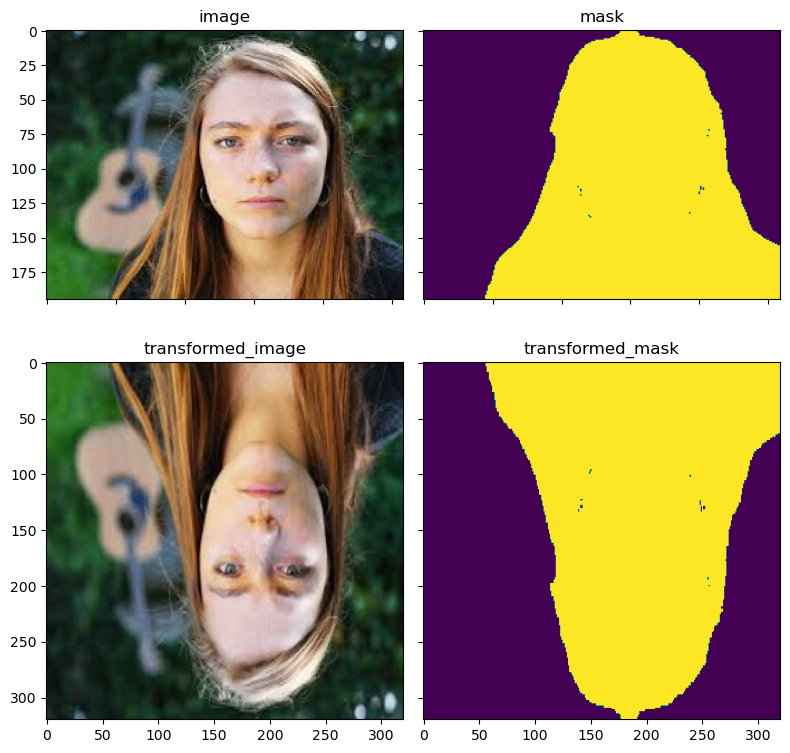

In [13]:
imgs_to_plot = [image, mask, transformed_image, transformed_mask]
imgs_to_title = ["image", "mask", "transformed_image", "transformed_mask"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(imgs_to_plot[i])
    ax.set_title(f"{(imgs_to_title[i])}")
    ax.label_outer()

plt.tight_layout()
plt.show()

`plot_original_and_augmented()`
A function to visualize original vs. augmented


image shape: (408, 612, 3)
mask shape: (408, 612)
transformed_image shape: (320, 320, 3)
transformed_mask shape: (320, 320)


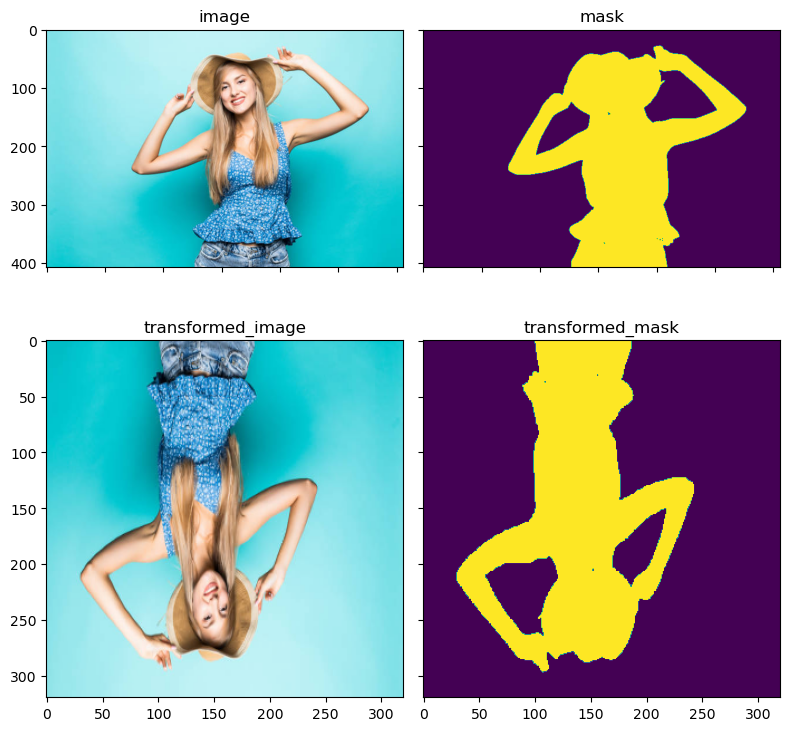

In [28]:
def plot_original_and_augmented(idx=0, df=df):

    row = df.iloc[idx]

    image_path = row["images"]
    mask_path = row["masks"]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED) / 255.0

    transformed = training_augs(image=image, mask=mask)
    transformed_image = transformed["image"]
    transformed_mask = transformed["mask"]

    imgs_to_plot = [image, mask, transformed_image, transformed_mask]
    img_titles = ["image", "mask", "transformed_image", "transformed_mask"]

    for i, img in enumerate(imgs_to_plot):
        print(f"{img_titles[i]} shape: {img.shape}")

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs_to_plot[i])
        ax.set_title(f"{(img_titles[i])}")
        ax.label_outer()

    plt.tight_layout()
    plt.show()


plot_original_and_augmented(idx=4, df=df)

image shape: (640, 480, 3)
mask shape: (577, 433)
transformed_image shape: (320, 320, 3)
transformed_mask shape: (320, 320)


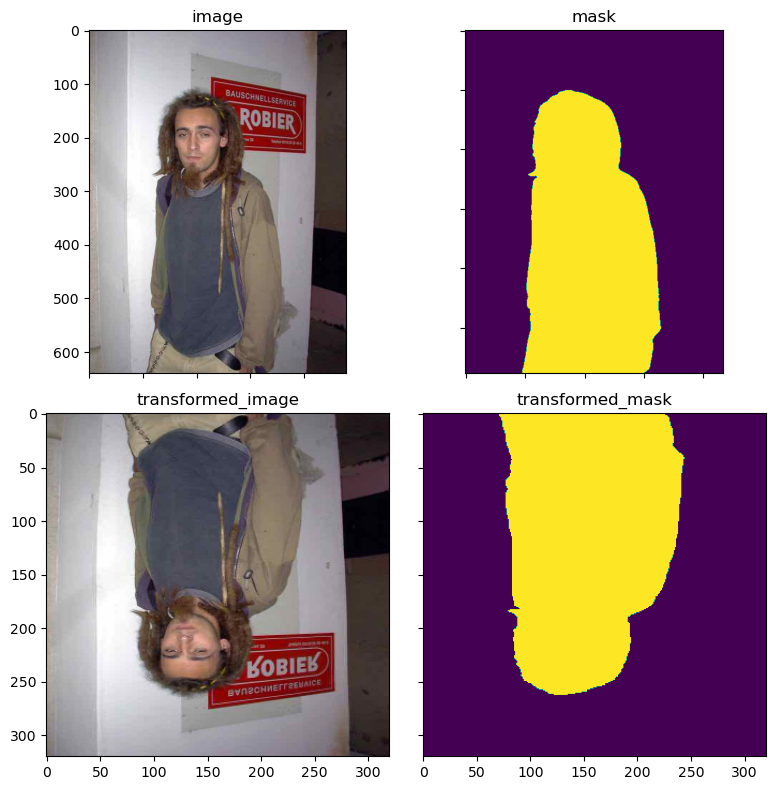

In [32]:
plot_original_and_augmented(idx=30, df=df)

image shape: (500, 750, 3)
mask shape: (408, 612)
transformed_image shape: (320, 320, 3)
transformed_mask shape: (320, 320)


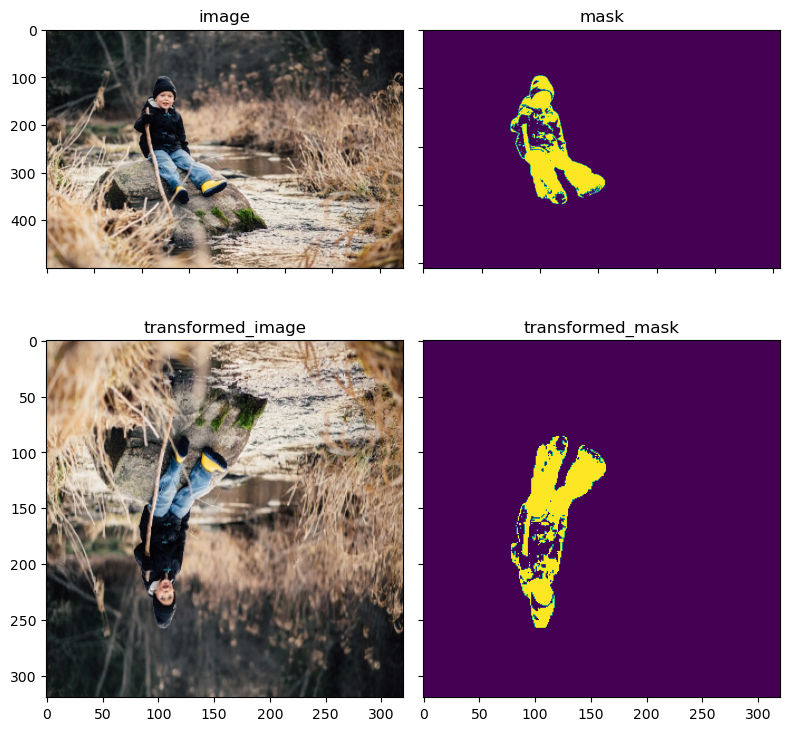

In [30]:
plot_original_and_augmented(idx=10, df=df)

image shape: (640, 480, 3)
mask shape: (577, 433)
transformed_image shape: (320, 320, 3)
transformed_mask shape: (320, 320)


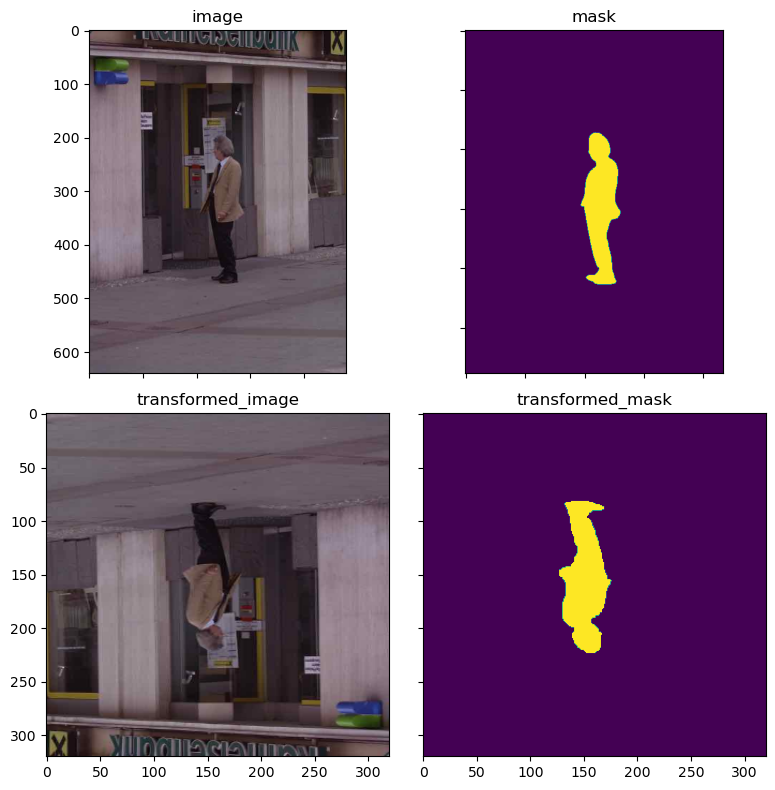

In [31]:
plot_original_and_augmented(idx=25, df=df)

# Create Custom Dataset


In [33]:
from torch.utils.data import Dataset

In [42]:
class SegmentationDataset(Dataset):

    def __init__(self, dataframe, augmentations: A.Compose | None = None):

        self.df = dataframe
        self.augmentations = augmentations

    def __len__(self):

        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        image_path = row["images"]
        mask_path = row["masks"]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # (h, w, c)
        mask = mask[..., np.newaxis]  # mask = np.expand_dims(mask, axis=-1)

        if self.augmentations is not None:
            data = self.augmentations(image=image, mask=mask)
            image = data["image"]
            mask = data["mask"]

        # (h, w, c) -> (c, h, w)
        # type(torch.float32)
        # torch.tensor()
        image = torch.tensor(image).permute(2, 0, 1).type(torch.float32) / 255.0
        mask = torch.round(
            torch.tensor(mask).permute(2, 0, 1).type(torch.float32) / 255.0
        )

        return image, mask


train_dataset = SegmentationDataset(train_df, training_augs)
val_dataset = SegmentationDataset(val_df, validation_augs)

print(f"Size of Trainset : {len(train_dataset)}")
print(f"Size of Validset : {len(val_dataset)}")

Size of Trainset : 232
Size of Validset : 58


torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


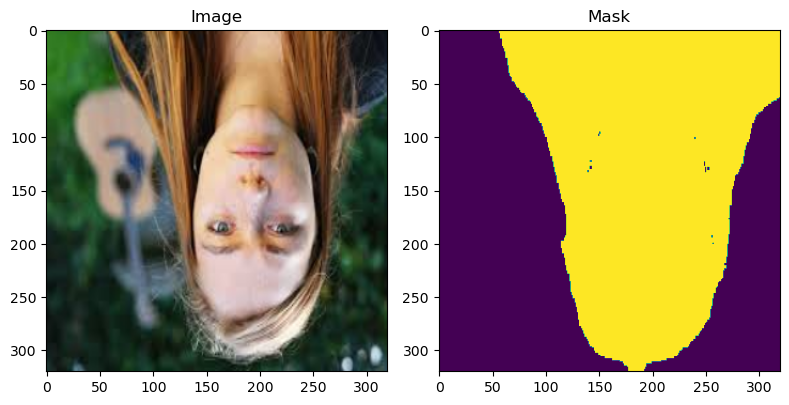

In [54]:
# image, mask = train_dataset[0]

# print(image.shape, mask.shape)

# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

# ax1.imshow(image.permute(1, 2, 0))
# ax1.set_title("Image")
# ax2.imshow(mask.permute(1, 2, 0))
# ax2.set_title("Mask")

# plt.tight_layout()
# plt.show()


def visualize_dataset_imgs(dataset=train_dataset, idx=0):
    image, mask = dataset[idx]

    print(image.shape, mask.shape)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

    ax1.imshow(image.permute(1, 2, 0))
    ax1.set_title("Image")
    ax2.imshow(mask.permute(1, 2, 0))
    ax2.set_title("Mask")

    plt.tight_layout()
    plt.show()


visualize_dataset_imgs(dataset=train_dataset, idx=0)

# Load Dataset into Batches


In [55]:
from torch.utils.data import DataLoader

In [57]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"total num. of batches in train_loader: {len(train_dataloader)}")
print(f"total num. of batches in valid_loader: {len(val_dataloader)}")

total num. of batches in train_loader: 8
total num. of batches in valid_loader: 2


One batch image shape: torch.Size([32, 3, 320, 320])
One batch mask shape: torch.Size([32, 1, 320, 320])


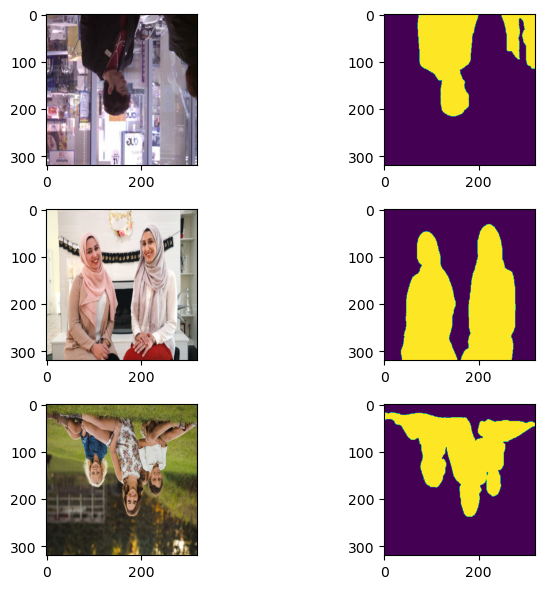

In [71]:
for image, mask in train_dataloader:
    break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 6))

for i in range(3):

    axes[i, 0].imshow(image[i].permute(1, 2, 0))
    axes[i, 1].imshow(mask[i].permute(1, 2, 0))

plt.tight_layout()
plt.show()

# axes[0, 0].imshow(image[0].permute(1, 2, 0))
# axes[0, 1].imshow(mask[0].permute(1, 2, 0))

# axes[1, 0].imshow(image[1].permute(1, 2, 0))
# axes[1, 1].imshow(mask[1].permute(1, 2, 0))

# axes[2, 0].imshow(image[2].permute(1, 2, 0))
# axes[2, 1].imshow(mask[2].permute(1, 2, 0))

# plt.tight_layout()
# plt.show()

# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/


In [72]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [75]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.architecture = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None,  # outputs raw logits
        )

    def forward(self, images, masks=None):

        logits = self.architecture(images)

        if masks is not None:
            loss1 = DiceLoss(mode="binary")(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        return logits

In [76]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /Users/benchen/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 29.9MB/s]


SegmentationModel(
  (architecture): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
  

# Create Train and Validation Function


In [77]:
def train_fn(model, train_dataloader, optimizer):

    model.train()
    total_loss = 0

    for batch_images, batch_masks in tqdm(train_dataloader):
        batch_images, batch_masks = batch_images.to(DEVICE), batch_masks.to(DEVICE)

        logits, loss = model(batch_images, batch_masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_dataloader)


def eval_fn(model, val_dataloader):

    model.eval()
    total_loss = 0

    with torch.inference_mode():
        for batch_images, batch_masks in tqdm(val_dataloader):
            batch_images, batch_masks = batch_images.to(DEVICE), batch_masks.to(DEVICE)

            logits, loss = model(batch_images, batch_masks)
            total_loss += loss.item()

    return total_loss / len(val_dataloader)

# Train the Model


In [79]:
model = SegmentationModel().to(DEVICE)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LR, weight_decay=0.1)

best_valid_loss = np.Inf

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    train_loss = train_fn(
        model=model, train_dataloader=train_dataloader, optimizer=optimizer
    )
    val_loss = eval_fn(model=model, val_dataloader=val_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pth")
        best_valid_loss = val_loss
        print("--- SAVED BEST MODEL ---")

    print(
        f"\nEpoch: {epoch+1:03d}/{NUM_EPOCHS:03d} (Best valid_loss: {best_valid_loss:.3f})\n"
        f" | Train_loss: {train_loss:.3f} | Valid_loss: {val_loss:.3f}"
    )

100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


--- SAVED BEST MODEL ---

Epoch: 001/025 (Best valid_loss: 1.267)
 | Train_loss: 0.999 | Valid_loss: 1.267


100%|██████████| 2/2 [00:00<00:00,  4.02it/s]



Epoch: 002/025 (Best valid_loss: 1.267)
 | Train_loss: 0.609 | Valid_loss: 1.453


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


--- SAVED BEST MODEL ---

Epoch: 003/025 (Best valid_loss: 0.641)
 | Train_loss: 0.469 | Valid_loss: 0.641


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]



Epoch: 004/025 (Best valid_loss: 0.641)
 | Train_loss: 0.387 | Valid_loss: 1.211


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


--- SAVED BEST MODEL ---

Epoch: 005/025 (Best valid_loss: 0.348)
 | Train_loss: 0.347 | Valid_loss: 0.348


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


--- SAVED BEST MODEL ---

Epoch: 006/025 (Best valid_loss: 0.258)
 | Train_loss: 0.291 | Valid_loss: 0.258


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


--- SAVED BEST MODEL ---

Epoch: 007/025 (Best valid_loss: 0.225)
 | Train_loss: 0.280 | Valid_loss: 0.225


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]



Epoch: 008/025 (Best valid_loss: 0.225)
 | Train_loss: 0.232 | Valid_loss: 0.250


100%|██████████| 2/2 [00:00<00:00,  4.40it/s]



Epoch: 009/025 (Best valid_loss: 0.225)
 | Train_loss: 0.203 | Valid_loss: 0.226


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


--- SAVED BEST MODEL ---

Epoch: 010/025 (Best valid_loss: 0.204)
 | Train_loss: 0.199 | Valid_loss: 0.204


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


--- SAVED BEST MODEL ---

Epoch: 011/025 (Best valid_loss: 0.202)
 | Train_loss: 0.182 | Valid_loss: 0.202


100%|██████████| 2/2 [00:00<00:00,  4.57it/s]



Epoch: 012/025 (Best valid_loss: 0.202)
 | Train_loss: 0.177 | Valid_loss: 0.230


100%|██████████| 2/2 [00:00<00:00,  4.54it/s]



Epoch: 013/025 (Best valid_loss: 0.202)
 | Train_loss: 0.186 | Valid_loss: 0.225


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]



Epoch: 014/025 (Best valid_loss: 0.202)
 | Train_loss: 0.182 | Valid_loss: 0.215


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


--- SAVED BEST MODEL ---

Epoch: 015/025 (Best valid_loss: 0.196)
 | Train_loss: 0.174 | Valid_loss: 0.196


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]



Epoch: 016/025 (Best valid_loss: 0.196)
 | Train_loss: 0.170 | Valid_loss: 0.225


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]



Epoch: 017/025 (Best valid_loss: 0.196)
 | Train_loss: 0.153 | Valid_loss: 0.208


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]



Epoch: 018/025 (Best valid_loss: 0.196)
 | Train_loss: 0.144 | Valid_loss: 0.225


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]



Epoch: 019/025 (Best valid_loss: 0.196)
 | Train_loss: 0.166 | Valid_loss: 0.198


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]



Epoch: 020/025 (Best valid_loss: 0.196)
 | Train_loss: 0.159 | Valid_loss: 0.202


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


--- SAVED BEST MODEL ---

Epoch: 021/025 (Best valid_loss: 0.195)
 | Train_loss: 0.160 | Valid_loss: 0.195


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]



Epoch: 022/025 (Best valid_loss: 0.195)
 | Train_loss: 0.138 | Valid_loss: 0.195


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


--- SAVED BEST MODEL ---

Epoch: 023/025 (Best valid_loss: 0.178)
 | Train_loss: 0.143 | Valid_loss: 0.178


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


--- SAVED BEST MODEL ---

Epoch: 024/025 (Best valid_loss: 0.175)
 | Train_loss: 0.116 | Valid_loss: 0.175


100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

--- SAVED BEST MODEL ---

Epoch: 025/025 (Best valid_loss: 0.169)
 | Train_loss: 0.119 | Valid_loss: 0.169


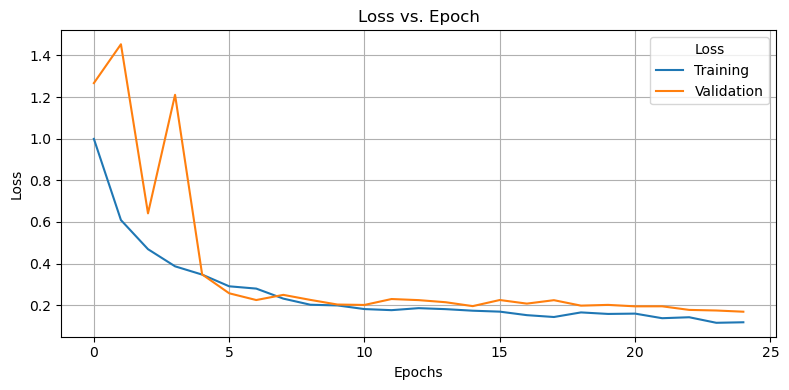

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(train_losses, label="Training")
ax.plot(val_losses, label="Validation")
ax.legend(title="Loss")
ax.set_title("Loss vs. Epoch")
ax.set(xlabel="Epochs", ylabel="Loss")
ax.grid(True)
# ax.axis(False)
# ax.axis("off")

plt.tight_layout()
plt.show()

# Inference


image.shape: torch.Size([3, 320, 320])
mask.shape: torch.Size([1, 320, 320])
{'logits_mask.shape: torch.Size([1, 1, 320, 320])'}
pred_mask_plotted.shape: torch.Size([1, 320, 320])


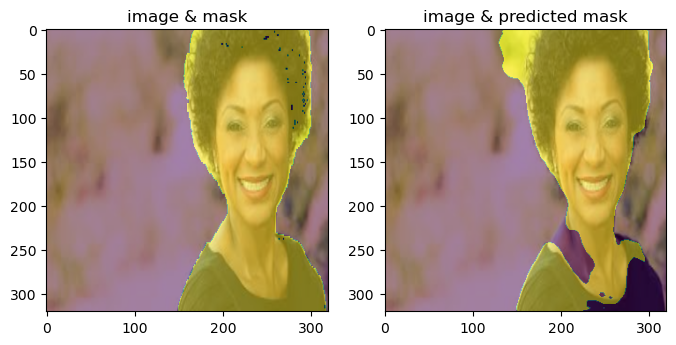

In [88]:
idx = 2

model = SegmentationModel()
model.load_state_dict(torch.load("best_model.pth"))
model.to(DEVICE)

image, mask = val_dataset[idx]
print(f"image.shape: {image.shape}")
print(f"mask.shape: {mask.shape}")

logits_mask = model(image.to(DEVICE).unsqueeze(dim=0))
print({f"logits_mask.shape: {logits_mask.shape}"})
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

pred_mask_plotted = pred_mask.detach().cpu().squeeze(dim=0)
print(f"pred_mask_plotted.shape: {pred_mask_plotted.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(image.permute(1, 2, 0))
ax1.imshow(mask.permute(1, 2, 0), alpha=0.5)
ax1.set_title("image & mask")

ax2.imshow(image.permute(1, 2, 0))
ax2.imshow(pred_mask_plotted.permute(1, 2, 0), alpha=0.5)
ax2.set_title("image & predicted mask")

plt.show()

type(test_img): <class 'numpy.ndarray'>, test_img.shape: (320, 320, 3)
type(test_img_tensor): <class 'torch.Tensor'>, test_img_tensor.shape: torch.Size([3, 320, 320])
pred_mask.shape: torch.Size([1, 1, 320, 320])
pred_mask_plotted.shape: torch.Size([1, 320, 320])


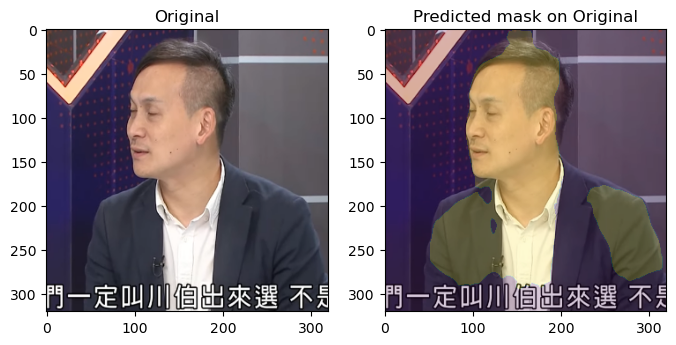

In [101]:
test_img = "people_imgs/someone1.png"
test_img = cv2.imread(test_img)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, dsize=(320, 320))
print(f"type(test_img): {type(test_img)}, test_img.shape: {test_img.shape}")

test_img_tensor = torch.tensor(test_img.transpose(2, 0, 1)).type(torch.float32)
print(
    f"type(test_img_tensor): {type(test_img_tensor)}, test_img_tensor.shape: {test_img_tensor.shape}"
)


with torch.inference_mode():
    logits_mask = model(test_img_tensor.to(DEVICE).unsqueeze(dim=0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0


print(f"pred_mask.shape: {pred_mask.shape}")

plottable_pred_mask = pred_mask.squeeze(dim=0).cpu().permute(1, 2, 0)
print(f"pred_mask_plotted.shape: {pred_mask_plotted.shape}")


fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(test_img)
ax[0].set_title("Original")
ax[1].imshow(test_img)
ax[1].imshow(plottable_pred_mask, alpha=0.2)
ax[1].set_title("Predicted mask on Original")

plt.show()